In [18]:
print("Hello chat gpt")

Hello chat gpt


In [19]:
!pip install pysentimiento transformers datasets accelerate evaluate
!pip install unidecode
!pip install accelerate

In [34]:
import pandas as pd
import string
from unidecode import unidecode
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
df = pd.read_excel("Experiencia_final.xlsx")

In [22]:
def asignar_etiqueta(calificacion):
    if calificacion in [1, 2]:
        return 'NEG'
    elif calificacion == 3:
        return 'NEU'
    elif calificacion in [4, 5]:
        return 'POS'
    else:
        return 'Desconocido'

# Aplica la función a la columna 'calificacion'
df['Etiqueta'] = df['calificacion'].apply(asignar_etiqueta)

df = df.drop(columns = ['calificacion'])

In [23]:
def limpiar_columna(columna):
    # Convertir a minúsculas, eliminar acentos y luego eliminar signos de puntuación y números
    columna_limpia = columna.apply(lambda x: unidecode(str(x).upper()))
    translator = str.maketrans('', '', string.punctuation + string.digits)
    columna_limpia = columna_limpia.apply(lambda x: str(x).translate(translator))
    return columna_limpia

def limpiar_base_de_datos(ruta_archivo_excel):
    # Cargar la base de datos desde Excel

    # Iterar sobre cada columna y aplicar la limpieza
    for columna in df.columns:
        df[columna] = limpiar_columna(df[columna])

def eliminar_articulos(columna):
    lista_palabras = []
    for i in columna:
        i = re.sub(r'\b(el|la|los|las|ellos)\b', '', i, flags=re.IGNORECASE)
        lista_palabras.append(i)
    return lista_palabras

def eliminar_palabras_vacias(columna):
    stop_words = set(stopwords.words('spanish'))
    lista_palabras = []
    for i in columna:
        palabras = nltk.word_tokenize(i)
        palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
        i = ' '.join(palabras_filtradas)
        lista_palabras.append(i)
    return lista_palabras

# Reemplaza 'ruta_del_archivo.xlsx' con la ruta real de tu archivo Excel
limpiar_base_de_datos('Experiencia_final.xlsx')
df['Comentario'] = eliminar_articulos(df['Comentario'])
df['Comentario'] = eliminar_palabras_vacias(df['Comentario'])
print(df)

                         ORGANIZACION  \
0                           TOKYOPLAY   
1           MUSEO REGIONAL DE CHOLULA   
2                 GURU THE BRAND BURO   
3                                IPAM   
4                                IPAM   
...                               ...   
1631  CONEKTICA AGENCIA DE PUBLICIDAD   
1632                           XCARET   
1633                        PREAMBULO   
1634                            BASE    
1635                      BIRTH GROUP   

                                             Comentario  \
0                                                         
1     LO QUE OCURRIO ES QUE NUNCA SE AUTORIZO PRESUP...   
2     FUE UNA EXCELENTE EXPERIENCIA QUE VIVI EN PRAC...   
3     ORGANIZACION NO TUVO CONTACTO CON NOSOTRAS MAS...   
4     ORGANIZACION PERDIO CONTACTO CON NOSOTRAS A PA...   
...                                                 ...   
1631  EN LO PERSONAL NO DISFRUTE MUCHO MIS PRACTICAS...   
1632                               

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pysentimiento import create_analyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re

model_name = "pysentimiento/robertuito-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128

analyzer = create_analyzer(task = 'sentiment', lang = 'es')

In [25]:
def predict(comment):
  return analyzer.predict(comment)

df['Analyzer'] = df['Comentario'].apply(predict)

In [26]:
print(df)

                         ORGANIZACION  \
0                           TOKYOPLAY   
1           MUSEO REGIONAL DE CHOLULA   
2                 GURU THE BRAND BURO   
3                                IPAM   
4                                IPAM   
...                               ...   
1631  CONEKTICA AGENCIA DE PUBLICIDAD   
1632                           XCARET   
1633                        PREAMBULO   
1634                            BASE    
1635                      BIRTH GROUP   

                                             Comentario  \
0                                                         
1     LO QUE OCURRIO ES QUE NUNCA SE AUTORIZO PRESUP...   
2     FUE UNA EXCELENTE EXPERIENCIA QUE VIVI EN PRAC...   
3     ORGANIZACION NO TUVO CONTACTO CON NOSOTRAS MAS...   
4     ORGANIZACION PERDIO CONTACTO CON NOSOTRAS A PA...   
...                                                 ...   
1631  EN LO PERSONAL NO DISFRUTE MUCHO MIS PRACTICAS...   
1632                               

In [27]:
df.to_csv('DataSetFinal.csv', index = False)

In [28]:
sentiment_mapping = {
    'NEU': 'NEU',
    'POS': 'POS',
    'NEG': 'NEG'
}

# Utilizar apply para aplicar la función lambda a cada fila de la columna AnalyzerOutput
df['Sentiment'] = df['Analyzer'].apply(lambda x: sentiment_mapping[x.output])

In [29]:
def count_sentiments(series):
    return series.value_counts()

# Aplicar groupby y luego la función personalizada
result = df.groupby('ORGANIZACION')['Sentiment'].apply(count_sentiments).unstack().fillna(0)

# Cambiar el nombre de las columnas para mayor claridad
result.columns = ['NEG', 'NEU', 'POS']

# Mostrar el resultado
print(result)

                               NEG  NEU  POS
ORGANIZACION                                
 MUJERES                       1.0  0.0  1.0
 REVITALIZA SA DE CV           0.0  0.0  1.0
A MENTORS                      2.0  1.0  4.0
AAMC INTERNACIONAL             0.0  2.0  0.0
ABANTU TALENT                  0.0  1.0  0.0
...                            ...  ...  ...
YB CAPITAL                     0.0  0.0  1.0
YOON IXIM CORAZON DE MAIZ      0.0  0.0  1.0
ZALOA LANGUAGES                0.0  0.0  1.0
ZALOA LENGUAGES                1.0  0.0  0.0
ZVA INTERIORES Y ARQUITECTURA  0.0  0.0  1.0

[793 rows x 3 columns]


In [30]:
result.to_csv('Results.csv', index = False)

In [31]:
max_neg = result['NEG'].max()
max_pos = result['POS'].max()

# Filtrar las filas que coinciden con el máximo de NEG
orgs_max_neg = result.loc[result['NEG'] == max_neg, 'NEG'].to_frame()

# Filtrar las filas que coinciden con el máximo de POS
orgs_max_pos = result.loc[result['POS'] == max_pos, 'POS'].to_frame()

# Imprimir la organización con el máximo de NEG y su cantidad
print("Organización(es) con el máximo de NEG:")
print(orgs_max_neg)

# Imprimir la organización con el máximo de POS y su cantidad
print("\nOrganización(es) con el máximo de POS:")
print(orgs_max_pos)

Organización(es) con el máximo de NEG:
                NEG
ORGANIZACION       
ACCURATE MEDIA  9.0

Organización(es) con el máximo de POS:
               POS
ORGANIZACION      
BIRTH GROUP   14.0


Matriz de Confusión:
[[916  89 261]
 [ 10 116  41]
 [ 36  73  94]]


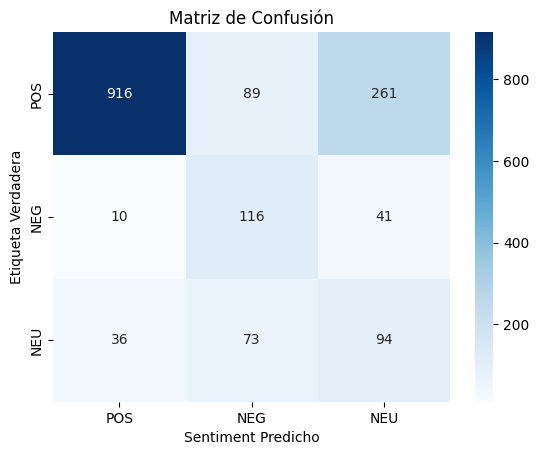

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la matriz de confusión
conf_matrix = confusion_matrix(df['Etiqueta'], df['Sentiment'], labels=['POS', 'NEG', 'NEU'])

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión con seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['POS', 'NEG', 'NEU'], yticklabels=['POS', 'NEG', 'NEU'])
plt.xlabel('Sentiment Predicho')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [35]:
# Calcular el total de instancias
total_instances = np.sum(conf_matrix)

# Calcular la diagonal de la matriz de confusión (instancias clasificadas correctamente)
correct_predictions = np.trace(conf_matrix)

# Calcular el porcentaje de aciertos
accuracy = correct_predictions / total_instances * 100

# Calcular el porcentaje de error
error_rate = (total_instances - correct_predictions) / total_instances * 100

# Mostrar los resultados
print(f'Porcentaje de Acierto: {accuracy:.2f}%')
print(f'Porcentaje de Error: {error_rate:.2f}%')

Porcentaje de Acierto: 68.83%
Porcentaje de Error: 31.17%
